# 002.04 EDA - Shots on Target 

In [1]:
import pathlib
import sys

import pandas as pd
import numpy as np

import scipy.stats as stats

from typing import List, Tuple, Union, Callable
from types import ModuleType

from statsmodels.graphics.mosaicplot import mosaic
# import scipy.stats as stats

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.mlab as mlab
import seaborn as sns

%matplotlib inline

# Load the "autoreload" extension
%load_ext autoreload
# always reload modules marked with "%aimport"
%autoreload 1
#add the 'src' directory to path to import modules
PROJECT_DIR = pathlib.Path.cwd().resolve().parent
sys.path.append(str(PROJECT_DIR))

from src.visualization.visualize import vstacked_bar_charts, diagnose_discrete_fit
from src.visualization.fit_dists import fit_nbinom

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

DATA_DIR = PROJECT_DIR / 'data'
SCOPED_DATA_DIR = DATA_DIR / '03-scoped'

## Three Seasons of English Premier League

In [2]:
league = 'english-premier-league'
load_fp = SCOPED_DATA_DIR / league / str(league + '-scoped-1.csv')
seasons = ['2009-2010', '2010-2011', '2011-2012']

In [3]:
df = pd.read_csv(load_fp, parse_dates = ['date'], index_col=None)
df = df[df['season'].isin(seasons)]
# Calculate Results column
conditions = [df['h_ftgoals'] > df['a_ftgoals'],
              df['h_ftgoals'] == df['a_ftgoals'],
              df['h_ftgoals'] < df['a_ftgoals']]
choices = ['hwin', 'draw', 'awin']
df['result'] = np.select(conditions, choices, default='not-played')
df.head()

,season,date,h,a,h_ftgoals,a_ftgoals,h_htgoals,a_htgoals,h_corners,h_fouls,h_ycards,h_rcards,h_shots,h_sot,a_corners,a_fouls,a_ycards,a_rcards,a_shots,a_sot,odds_hwin_bbmean,odds_draw_bbmean,odds_awin_bbmean,odds_hwin_bbmax,odds_draw_bbmax,odds_awin_bbmax,odds_hwin_WH,odds_draw_WH,odds_awin_WH,odds_ftgoalsu2.5_bbmax,odds_ftgoalso2.5_bbmax,odds_ftgoalsu2.5_bbmean,odds_ftgoalso2.5_bbmean,heatmap_path,shotmap_path,result
0,2009-2010,2009-08-15,aston-villa,wigan-athletic,0.0,2.0,0.0,1.0,4.0,15.0,2.0,0.0,11.0,5.0,6.0,14.0,2.0,0.0,14.0,7.0,1.66,3.51,5.33,1.72,3.77,6.05,1.70,3.4,5.50,1.91,2.04,1.81,1.92,/data/02-interim/football-data/english-premier...,/data/02-interim/football-data/english-premier...,awin
1,2009-2010,2009-08-15,blackburn-rovers,manchester-city,0.0,2.0,0.0,1.0,5.0,12.0,2.0,0.0,17.0,9.0,4.0,9.0,1.0,0.0,8.0,5.0,3.37,3.24,2.12,3.78,3.35,2.25,3.50,3.2,2.15,1.78,2.15,1.71,2.04,/data/02-interim/football-data/english-premier...,/data/02-interim/football-data/english-premier...,awin
2,2009-2010,2009-08-15,bolton-wanderers,sunderland,0.0,1.0,0.0,1.0,4.0,16.0,2.0,0.0,11.0,3.0,7.0,10.0,1.0,0.0,20.0,13.0,2.24,3.20,3.15,2.37,3.31,3.40,2.30,3.2,3.20,1.70,2.25,1.66,2.12,/data/02-interim/football-data/english-premier...,/data/02-interim/football-data/english-premier...,awin
3,2009-2010,2009-08-15,chelsea,hull-city,2.0,1.0,1.0,1.0,12.0,13.0,1.0,0.0,26.0,12.0,4.0,15.0,2.0,0.0,7.0,3.0,1.17,6.26,16.39,1.20,7.71,23.14,1.17,6.5,21.00,2.44,1.67,2.26,1.58,/data/02-interim/football-data/english-premier...,/data/02-interim/football-data/english-premier...,hwin
4,2009-2010,2009-08-15,everton,arsenal,1.0,6.0,0.0,3.0,4.0,11.0,0.0,0.0,8.0,5.0,9.0,13.0,0.0,0.0,15.0,9.0,3.07,3.21,2.28,3.34,3.34,2.42,3.20,3.2,2.30,1.77,2.20,1.70,2.06,/data/02-interim/football-data/english-premier...,/data/02-interim/football-data/english-premier...,awin


## Shots On Target

In [4]:
h_sots = df['h_sot'].dropna().astype('int')
a_sots = df['a_sot'].dropna().astype('int')

h_sots_mean = df['h_sot'].mean()
a_sots_mean = df['a_sot'].mean()

h_sots_var = df['h_sot'].var()
a_sots_var = df['a_sot'].var()

print(f'Home SOT:\nMean:\t\t{h_sots_mean}\nVariance:\t{h_sots_var}')
print(f'Away SOT:\nMean:\t\t{a_sots_mean}\nVariance:\t{a_sots_var}')

Home SOT:
Mean:		7.858771929824561
Variance:	12.87994932458443
Away SOT:
Mean:		6.121052631578947
Variance:	10.03625525622661


In [5]:
# Need to deal with any shot value that has no occurrences in any game
# eg 2 games have 5 shots | 0 games have 6 shots | 1 game has 7 shots
# !! Important to do this every freq count
max_sots = df[['h_sot', 'a_sot']].max().max().astype('int')
h_sots_val_counts = h_sots.value_counts()
h_sots_dist = h_sots.value_counts().sort_index(). \
                    reindex(range(max_sots+1), fill_value=0)
a_sots_val_counts = a_sots.value_counts()
a_sots_dist = a_sots.value_counts().sort_index(). \
                    reindex(range(max_sots+1), fill_value=0)    

sots_dists = pd.concat([h_sots_dist, a_sots_dist], axis=1)


print(f'Home and Away Goals Distributions:\n\n{sots_dists}\n')

Home and Away Goals Distributions:

    h_sot  a_sot
0       2     11
1      16     37
2      31     84
3      59    118
4      87    140
5     114    149
6     127    132
7     139    119
8     136     89
9      96     91
10     82     61
11     73     46
12     62     24
13     38     16
14     20     15
15     19      1
16     18      2
17      7      3
18      8      1
19      3      0
20      1      1
21      1      0
22      0      0
23      0      0
24      1      0



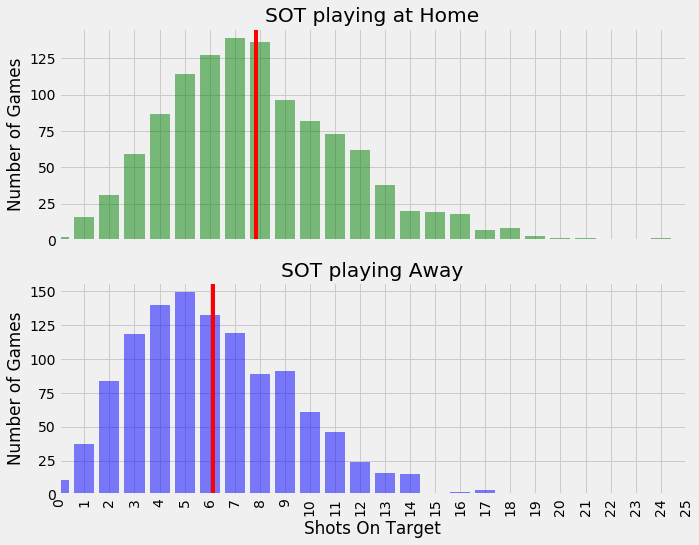

In [6]:
plt.style.use('fivethirtyeight')
fig, (ax1, ax2) = plt.subplots(ncols=1, nrows=2,figsize=(10,8), sharex=True)


ax1.bar(sots_dists.index, sots_dists['h_sot'], color='g', alpha=0.5, label='Home SOT')
ax1.axvline(h_sots_mean, color='r')
ax1.set_title('SOT playing at Home')
ax1.set_ylabel('Number of Games')

ax2.bar(sots_dists.index, sots_dists['a_sot'], color='b', alpha=0.5, label='Away SOT')
ax2.axvline(a_sots_mean, color='r')
ax2.set_title('SOT playing Away')
ax2.set_ylabel('Number of Games')
ax2.set_xlabel('Shots On Target')
ax2.set_xlim(0, len(sots_dists))

tick_spacing = 1
ax2.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
plt.xticks(rotation=90)

plt.show();

In [7]:
## Need QQ Plots here

#If needed, try transform

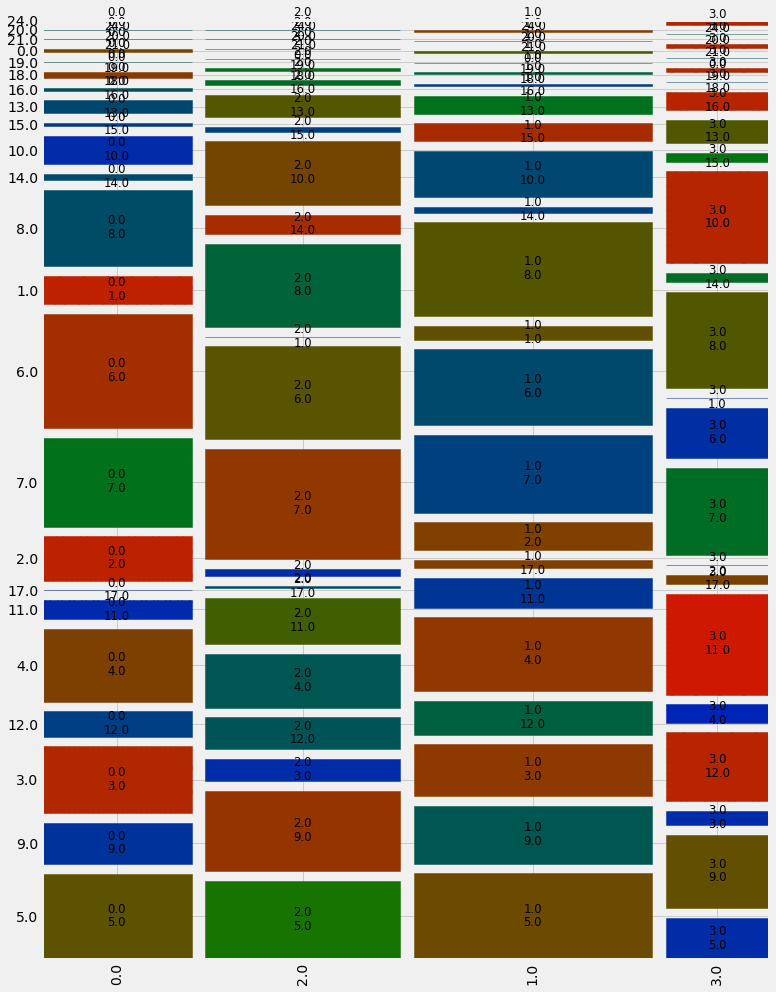

In [8]:
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(ncols=1, nrows=1,figsize=(11,14))
cut_df = df[df['h_ftgoals'] < 4]
data = cut_df[['h_sot', 'h_ftgoals']]
mosaic(data, ['h_ftgoals', 'h_sot'], statistic=True, ax=ax, label_rotation=[90,0], gap=0.02)
#fig.set_size_inches((10,8))#.fig
plt.tight_layout()
plt.show();

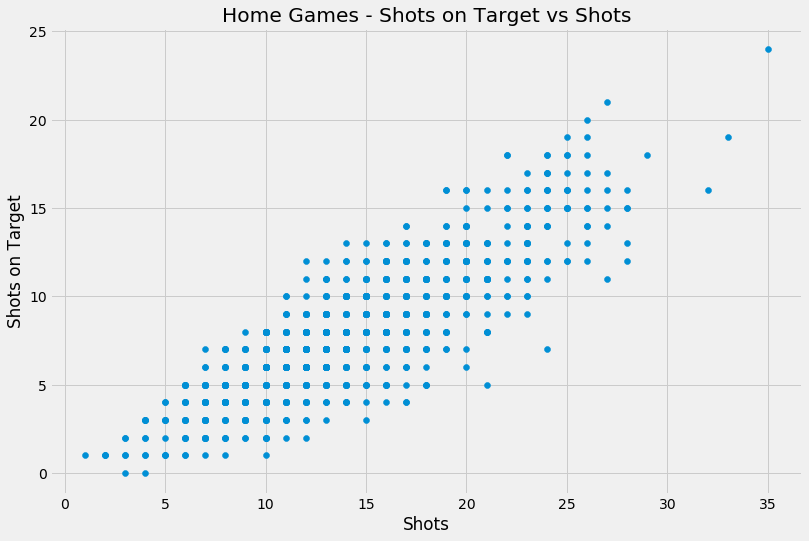

In [9]:
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(df['h_shots'], df['h_sot'])
ax.set_xlabel('Shots')
ax.set_ylabel('Shots on Target')
ax.set_title('Home Games - Shots on Target vs Shots')

plt.show();

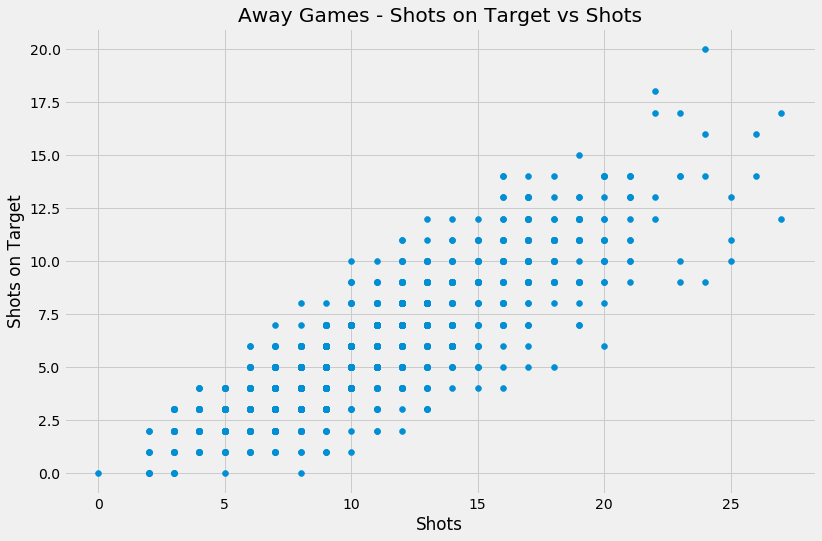

In [10]:
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(df['a_shots'], df['a_sot'])
ax.set_xlabel('Shots')
ax.set_ylabel('Shots on Target')
ax.set_title('Away Games - Shots on Target vs Shots')

plt.show();

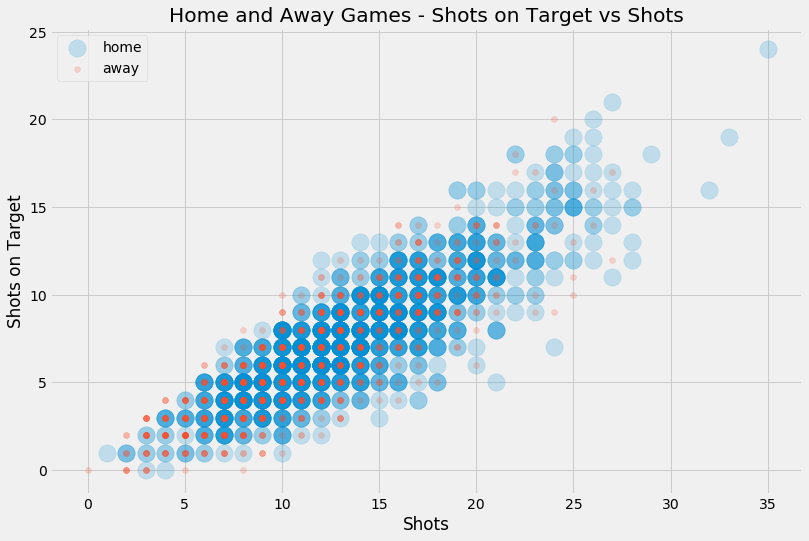

In [11]:
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(df['h_shots'], df['h_sot'], s=300, alpha=0.2, label='home')
ax.scatter(df['a_shots'], df['a_sot'], alpha=0.2, label='away')
ax.set_xlabel('Shots')
ax.set_ylabel('Shots on Target')
ax.set_title('Home and Away Games - Shots on Target vs Shots')

plt.legend()
plt.show();

# Conversion Rate

In [12]:
df['h_conv_rate'] = df['h_sot']/df['h_shots']
df.head()

,season,date,h,a,h_ftgoals,a_ftgoals,h_htgoals,a_htgoals,h_corners,h_fouls,h_ycards,h_rcards,h_shots,h_sot,a_corners,a_fouls,a_ycards,a_rcards,a_shots,a_sot,odds_hwin_bbmean,odds_draw_bbmean,odds_awin_bbmean,odds_hwin_bbmax,odds_draw_bbmax,odds_awin_bbmax,odds_hwin_WH,odds_draw_WH,odds_awin_WH,odds_ftgoalsu2.5_bbmax,odds_ftgoalso2.5_bbmax,odds_ftgoalsu2.5_bbmean,odds_ftgoalso2.5_bbmean,heatmap_path,shotmap_path,result,h_conv_rate
0,2009-2010,2009-08-15,aston-villa,wigan-athletic,0.0,2.0,0.0,1.0,4.0,15.0,2.0,0.0,11.0,5.0,6.0,14.0,2.0,0.0,14.0,7.0,1.66,3.51,5.33,1.72,3.77,6.05,1.70,3.4,5.50,1.91,2.04,1.81,1.92,/data/02-interim/football-data/english-premier...,/data/02-interim/football-data/english-premier...,awin,0.454545
1,2009-2010,2009-08-15,blackburn-rovers,manchester-city,0.0,2.0,0.0,1.0,5.0,12.0,2.0,0.0,17.0,9.0,4.0,9.0,1.0,0.0,8.0,5.0,3.37,3.24,2.12,3.78,3.35,2.25,3.50,3.2,2.15,1.78,2.15,1.71,2.04,/data/02-interim/football-data/english-premier...,/data/02-interim/football-data/english-premier...,awin,0.529412
2,2009-2010,2009-08-15,bolton-wanderers,sunderland,0.0,1.0,0.0,1.0,4.0,16.0,2.0,0.0,11.0,3.0,7.0,10.0,1.0,0.0,20.0,13.0,2.24,3.20,3.15,2.37,3.31,3.40,2.30,3.2,3.20,1.70,2.25,1.66,2.12,/data/02-interim/football-data/english-premier...,/data/02-interim/football-data/english-premier...,awin,0.272727
3,2009-2010,2009-08-15,chelsea,hull-city,2.0,1.0,1.0,1.0,12.0,13.0,1.0,0.0,26.0,12.0,4.0,15.0,2.0,0.0,7.0,3.0,1.17,6.26,16.39,1.20,7.71,23.14,1.17,6.5,21.00,2.44,1.67,2.26,1.58,/data/02-interim/football-data/english-premier...,/data/02-interim/football-data/english-premier...,hwin,0.461538
4,2009-2010,2009-08-15,everton,arsenal,1.0,6.0,0.0,3.0,4.0,11.0,0.0,0.0,8.0,5.0,9.0,13.0,0.0,0.0,15.0,9.0,3.07,3.21,2.28,3.34,3.34,2.42,3.20,3.2,2.30,1.77,2.20,1.70,2.06,/data/02-interim/football-data/english-premier...,/data/02-interim/football-data/english-premier...,awin,0.625000


count    1140.000000
mean        0.556669
std         0.147081
min         0.000000
25%         0.466667
50%         0.562500
75%         0.666667
max         1.000000
Name: h_conv_rate, dtype: float64

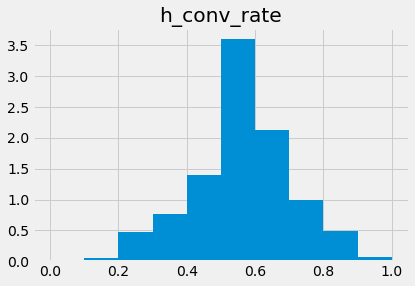

In [13]:
df.hist(column=['h_conv_rate'], density=True);
df['h_conv_rate'].describe()

In [14]:
df['a_conv_rate'] = df['a_sot']/df['a_shots']
df.head()
df['a_conv_rate'].describe()

count    1139.000000
mean        0.545486
std         0.171061
min         0.000000
25%         0.428571
50%         0.555556
75%         0.666667
max         1.000000
Name: a_conv_rate, dtype: float64

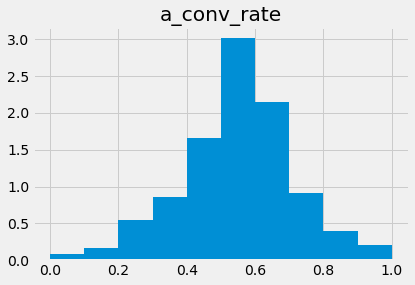

In [15]:
df.hist(column=['a_conv_rate'], density=True);

In [16]:
df['h1_conv_rate'] = df['h_ftgoals']/df['h_sot']
df['h1_conv_rate'].replace([np.inf, -np.inf], np.nan, inplace=True)
df['h1_conv_rate'].dropna(inplace=True)
#df['h_conv_rate'] = df['h_sot']/df['h_shots']
#df.head()
df['h1_conv_rate'].head()

0    0.000000
1    0.000000
2    0.000000
3    0.166667
4    0.200000
Name: h1_conv_rate, dtype: float64

In [17]:
df['h1_conv_rate'].describe()

count    1138.000000
mean        0.225136
std         0.190551
min         0.000000
25%         0.090909
50%         0.200000
75%         0.333333
max         1.000000
Name: h1_conv_rate, dtype: float64

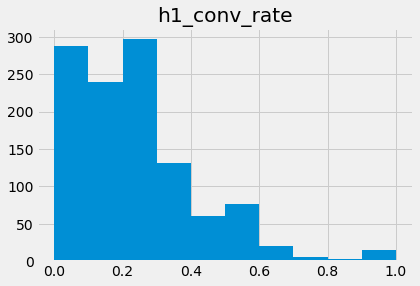

In [18]:
df.hist(column=['h1_conv_rate']);

In [19]:
df['a1_conv_rate'] = df['a_ftgoals']/df['a_sot']
#df.head()
df['a1_conv_rate'].describe()

count    1129.000000
mean        0.204756
std         0.223521
min         0.000000
25%         0.000000
50%         0.166667
75%         0.333333
max         2.000000
Name: a1_conv_rate, dtype: float64

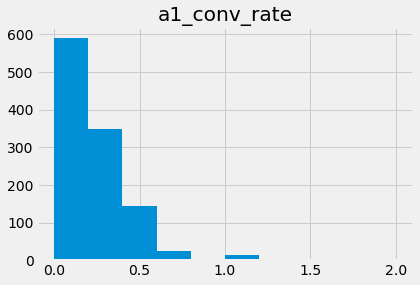

In [20]:
df.hist(column=['a1_conv_rate']);

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26]),
 <a list of 26 Text xticklabel objects>)

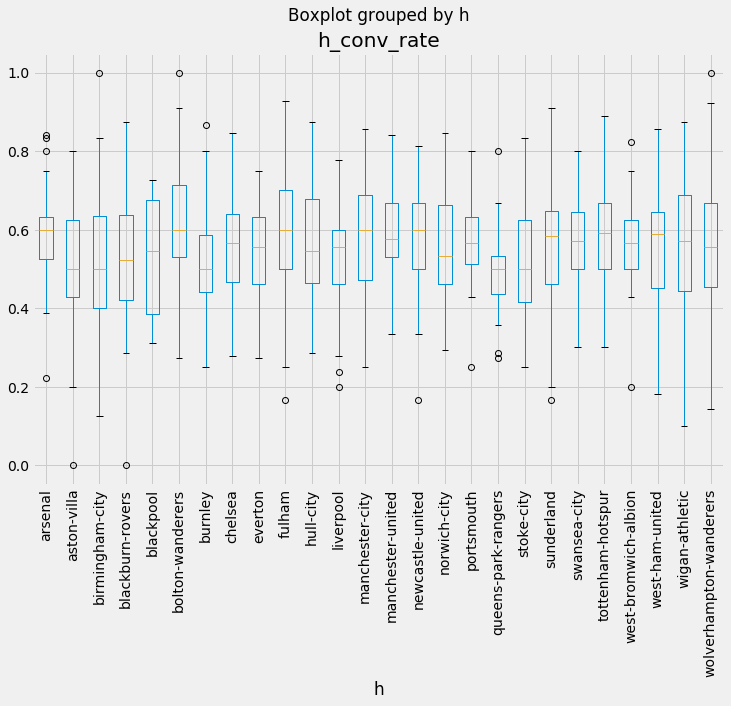

In [21]:
fig, ax = plt.subplots(figsize=(12,8))
plt.suptitle('')
df.boxplot(column=['h_conv_rate'], by='h', ax=ax)
plt.xticks(rotation=90)

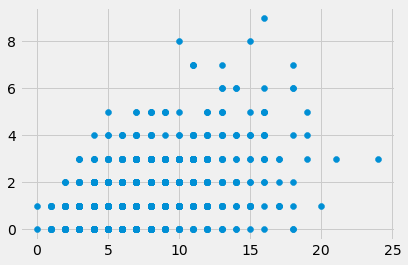

In [22]:
plt.scatter(df['h_sot'], df['h_ftgoals'])

NOTE - FUTURE DIRECTION

If we assume that historical sots is a reasonably good predictor of future sots

And sots is related to goals scored, but it is related very noisily by the distribution shown above

If we approximate this as a skewed normal, or an exponentially modified gaussian, then we can predict goals from sot

OR, we can assume a stright line from bottom left to top right, which is massively messed up by significant noise

We can use a Mixture Density Network to estimate the underlying struture plus the noise

https://engineering.taboola.com/predicting-probability-distributions/

https://en.wikipedia.org/wiki/Skew_normal_distribution

https://en.wikipedia.org/wiki/Exponentially_modified_Gaussian_distribution

This will give us a distribution we can samle from to get probability of game scores

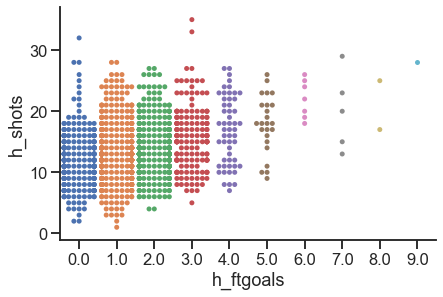

In [23]:
import seaborn as sns

sns.set(style='ticks', context='talk')
#iris = sns.load_dataset('iris')

sns.swarmplot(df['h_ftgoals'], df['h_shots'])#'species', 'sepal_length', data=iris)
sns.despine()

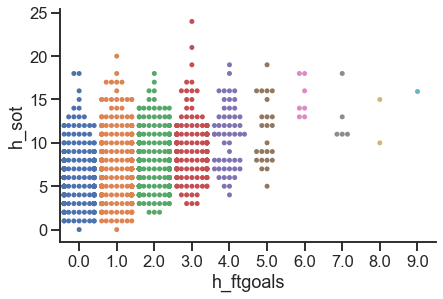

In [24]:
sns.set(style='ticks', context='talk')
#iris = sns.load_dataset('iris')

sns.swarmplot(df['h_ftgoals'], df['h_sot'])#'species', 'sepal_length', data=iris)
sns.despine()

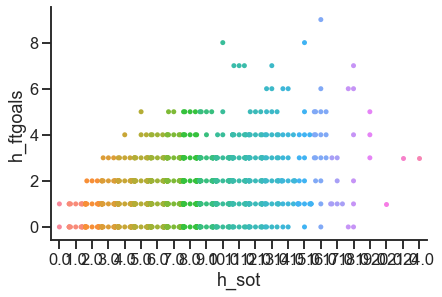

In [25]:
sns.set(style='ticks', context='talk')
sns.swarmplot(df['h_sot'], df['h_ftgoals'])#'species', 'sepal_length', data=iris)
sns.despine()

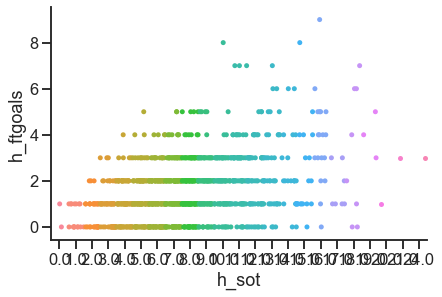

In [26]:
sns.stripplot(df['h_sot'], df['h_ftgoals'], jitter=0.5)
sns.despine()
             

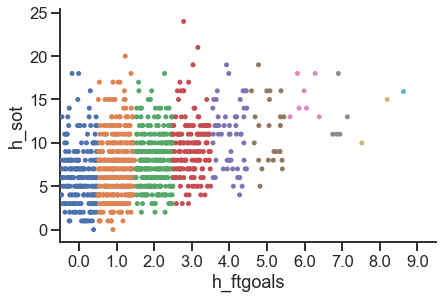

In [27]:
sns.stripplot(df['h_ftgoals'], df['h_sot'], jitter=0.5)
sns.despine()

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26]),
 <a list of 26 Text xticklabel objects>)

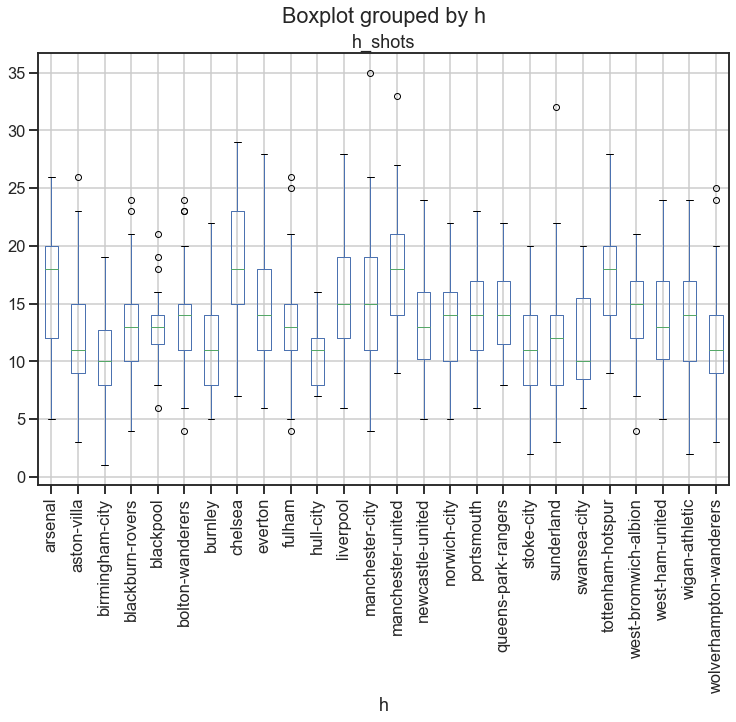

In [28]:
fig, ax = plt.subplots(figsize=(12,8))
plt.suptitle('')
df.boxplot(column=['h_shots'], by='h', ax=ax)
plt.xticks(rotation=90)

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26]),
 <a list of 26 Text xticklabel objects>)

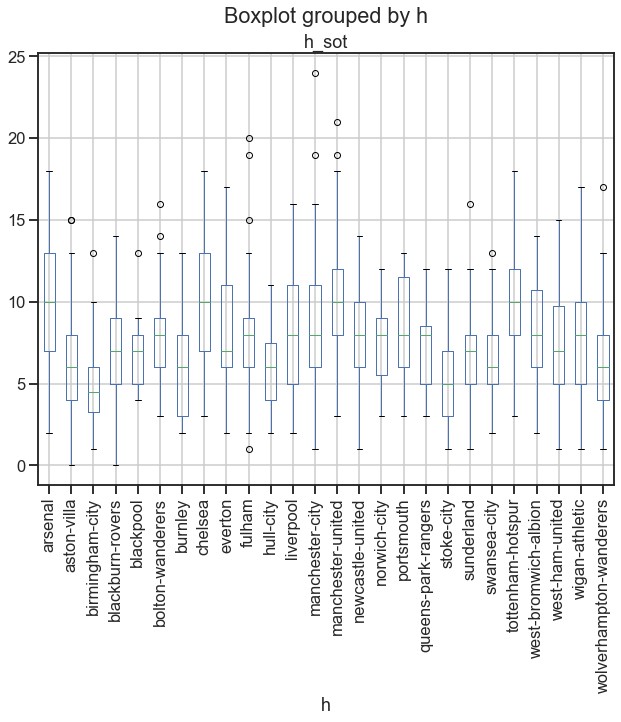

In [29]:
fig, ax = plt.subplots(figsize=(10,8))
plt.suptitle('')
df.boxplot(column=['h_sot'], by='h', ax=ax)
plt.xticks(rotation=90)

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26]),
 <a list of 26 Text xticklabel objects>)

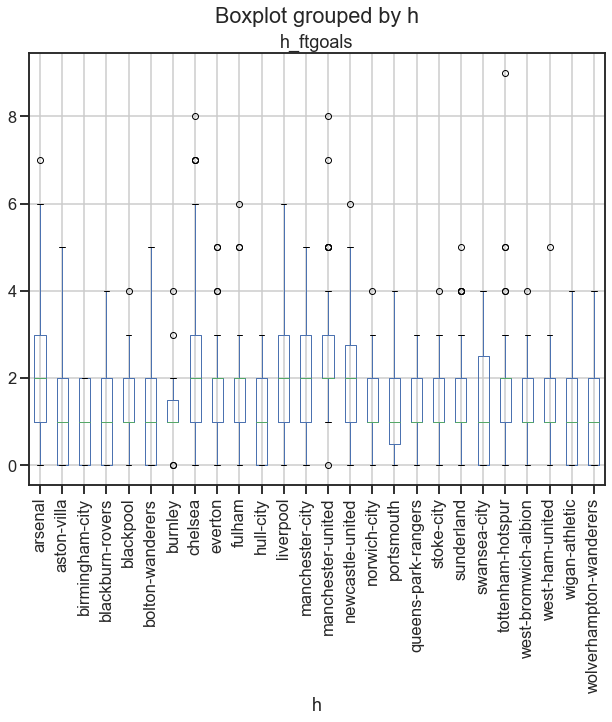

In [30]:
fig, ax = plt.subplots(figsize=(10,8))
plt.suptitle('')
df.boxplot(column=['h_ftgoals'], by='h', ax=ax)
plt.xticks(rotation=90)

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26]),
 <a list of 26 Text xticklabel objects>)

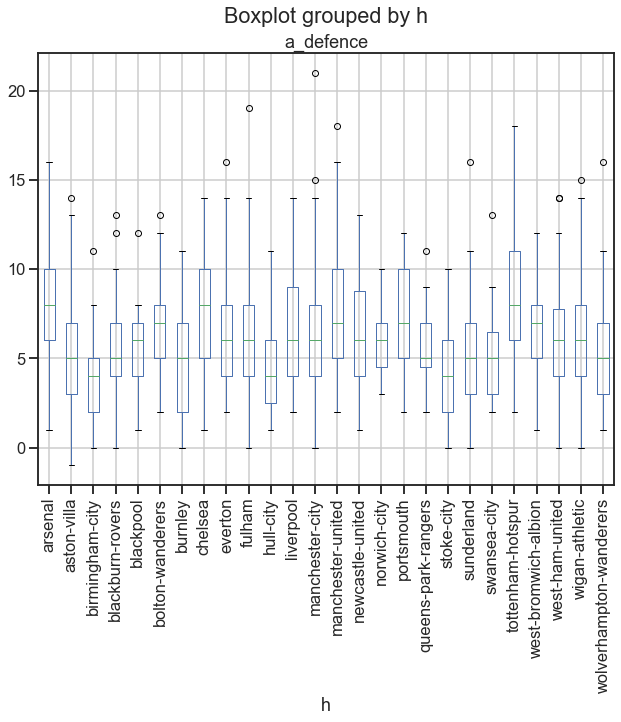

In [31]:
df['h_defence'] = df['a_sot'] - df['a_ftgoals']
df['a_defence'] = df['h_sot'] - df['h_ftgoals']
fig, ax = plt.subplots(figsize=(10,8))
plt.suptitle('')
df.boxplot(column=['a_defence'], by='h', ax=ax)
plt.xticks(rotation=90)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2a61b1d198>]],
      dtype=object)

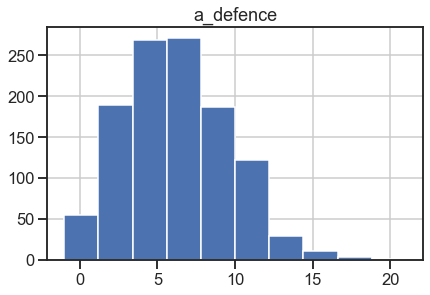

In [32]:
df.hist(column=['a_defence'])

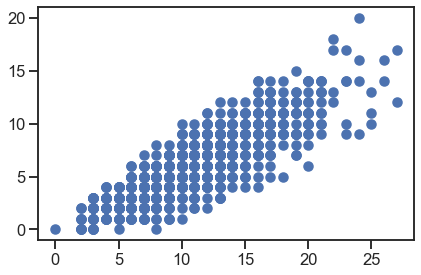

In [33]:

plt.scatter(df['a_shots'], df['a_sot'])

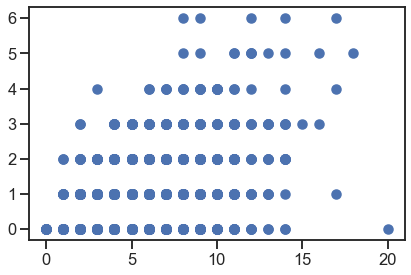

In [34]:
plt.scatter(df['a_sot'], df['a_ftgoals'])

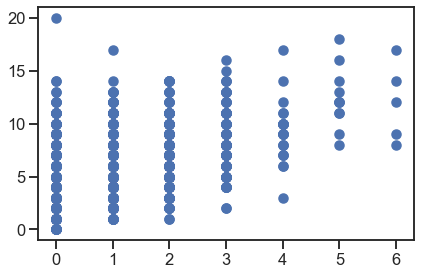

In [35]:
plt.scatter(df['a_ftgoals'], df['a_sot'])

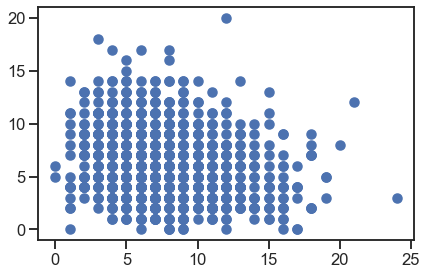

In [36]:
plt.scatter(df['h_sot'], df['a_sot'])

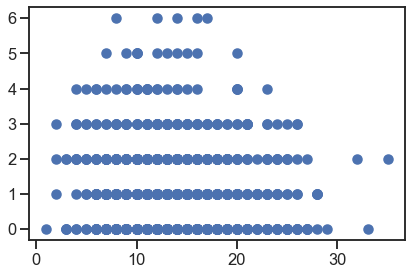

In [37]:
plt.scatter(df['h_shots'], df['a_ftgoals'])